<a href="https://colab.research.google.com/github/WuzI38/Data/blob/Jupyter/MidiGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Second attempt on music generation

## Download data

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [4]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download programgeek01/anime-music-midi

anime-music-midi.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
# Debug
!pip install -Uqq ipdb --use-deprecated=legacy-resolver
import ipdb

In [7]:
# Unzip data
import zipfile

zip_ref = zipfile.ZipFile("anime-music-midi.zip", "r") # Hey, don't blame me for the name, I am not this dataset's creator
zip_ref.extractall()
zip_ref.close()

In [8]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# enables playing midi files
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null

# Copy soundfont to content directory
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

installing lilypond...
installing fluidsynth...


## Loading and preprocessing

### Parsing files

In [9]:
import os
from music21 import *
from fractions import Fraction

path = "/content/data/undertale/"
midi_list = []
for filename in os.listdir(path):
  # print(filename)
  parsed_file = converter.parse(path + filename)
  midi_list.append(parsed_file)

In [10]:
midi_list[0]

<music21.stream.Score 0x7f1f4cf63310>

### Extracting notes and chords



In [11]:
import music21
def fragmentise(midi_stream: music21.stream.Score) -> list:
  return [part.flat.notes for part in midi_stream.parts]

In [12]:
def signature(midi_stream: music21.stream.Score) -> list:
  sig = midi_stream.getTimeSignatures()[0]
  return [sig.numerator, sig.denominator]

In [13]:
frag = fragmentise(midi_list[2])
frag

[<music21.stream.iterator.StreamIterator for Part:0x7f1f4c7c5190_flat @:0>]

In [14]:
sg = signature(frag[0])
sg

[4, 4]

In [15]:
# Part one - extract notes from both streams and save them into a list
def get_all_notes(midi_piece: music21.stream.Score) -> list:
  all_notes = list()
  note_types = set()
  midi_part = fragmentise(midi_piece)[0] # use only notes that belong to main melody
  for nt in midi_part.flat.notes: 
    if isinstance(nt, note.Note):
      pitch = str(max(0.0, nt.pitch.ps))
    elif isinstance(nt, chord.Chord):
      pitch = sorted([str(max(0.0, n.ps)) for n in nt.pitches])
      pitch = ' '.join(pitch)
    ql = nt.duration.quarterLength
    all_notes.append([nt.offset, pitch, ql if ql > 0.0 else 0.25]) # If for some reason len is 0 replace it with 0.25
  return all_notes
  
notes_list = get_all_notes(midi_list[1])
notes_list[:10]

[[14.0, '70.0', 0.5],
 [15.0, '72.0', 1.0],
 [16.0, '74.0', 0.25],
 [16.5, '75.0', 0.25],
 [17.0, '77.0', 2.0],
 [20.0, '70.0', 0.5],
 [21.0, '72.0', 1.0],
 [22.0, '76.0', 0.25],
 [22.5, '77.0', 0.25],
 [23.0, '79.0', 2.0]]

In [16]:
# Part 2 extract all chord types from the dataset
import numpy as np

def get_chord_types(dataset: list) -> dict:
  chord_types = dict()
  for d in dataset:
    notes_list = np.array(get_all_notes(d))
    strings = notes_list[:, 1]
    for s in strings:
      chord_types[s] = 1 + chord_types[s] if chord_types.get(s) is not None else 1
  return chord_types

types = get_chord_types(midi_list)

In [17]:
print(len(types))

1881


### Counting invidual chords and removing the rare ones

In [18]:
chord_counts = dict()
for item in sorted(list(types.values())):
  chord_counts[str(item)] = 1 + chord_counts[str(item)] if chord_counts.get(str(item)) is not None else 1

chord_counts = {k: v for k, v in chord_counts.items() if v > 1}

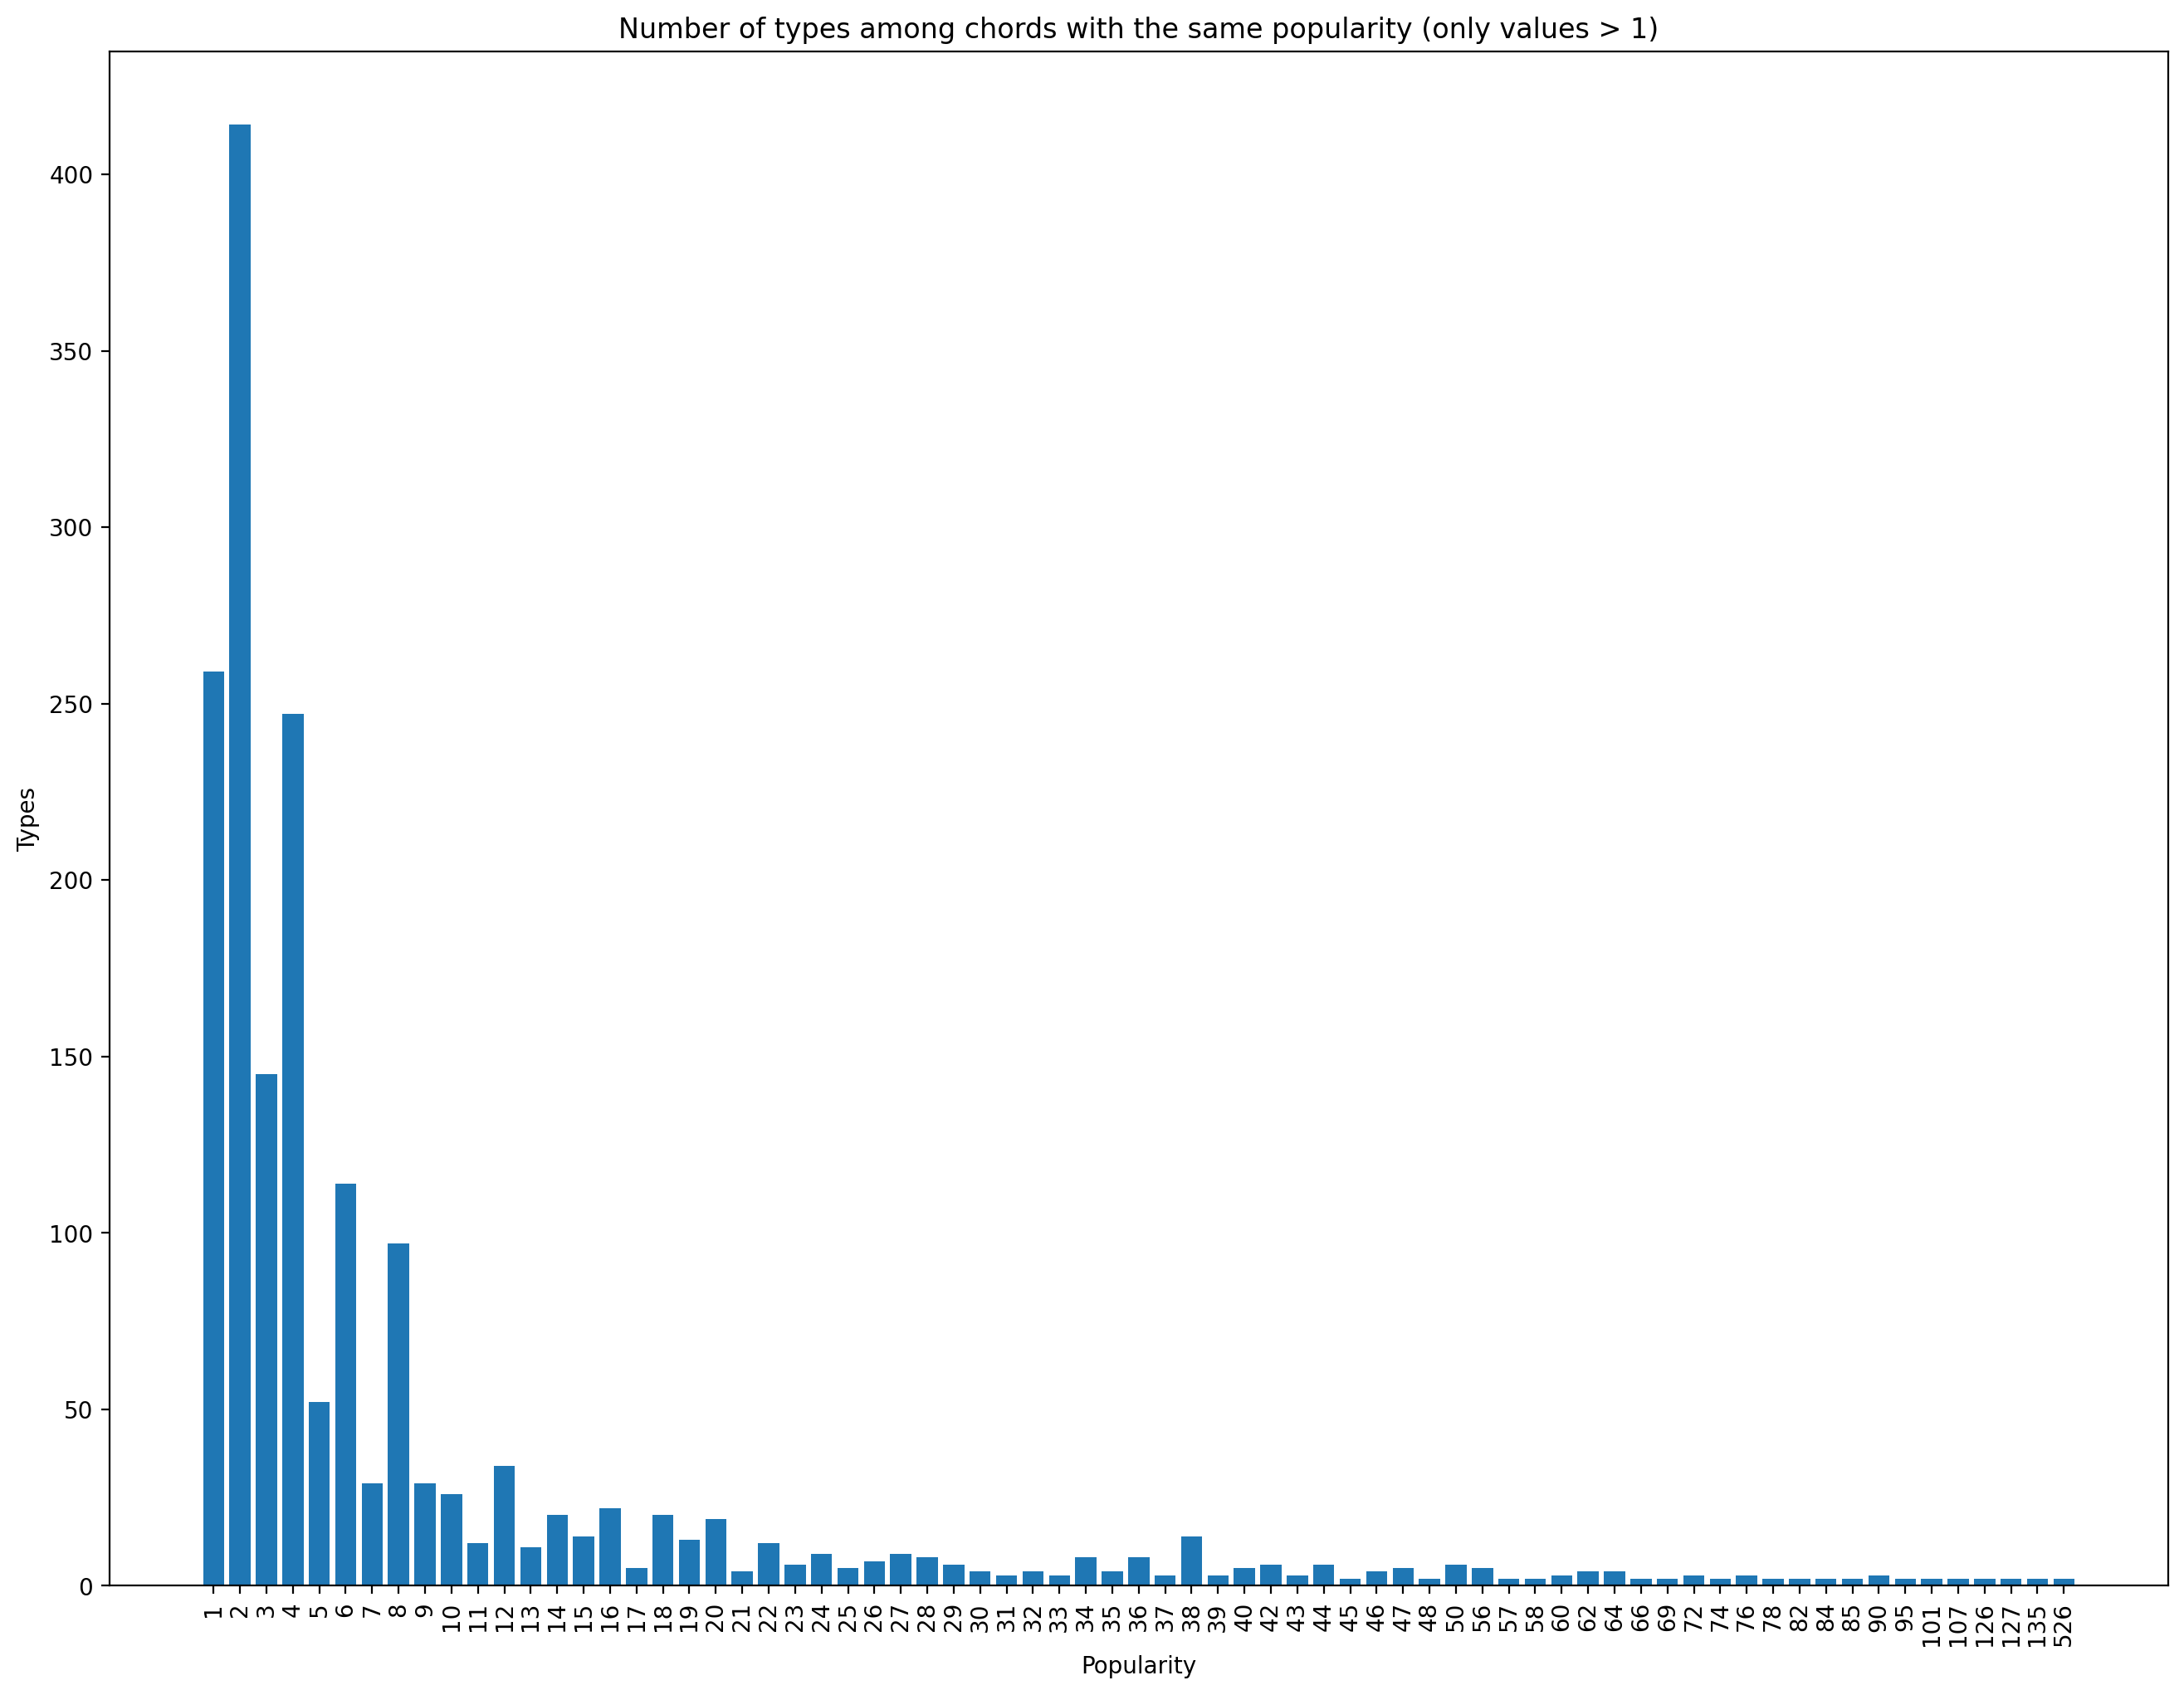

In [19]:
# Plotting the values
import matplotlib.pyplot as plt

# Extract the keys and values from the dictionary as lists
keys = list(chord_counts.keys())
values = list(chord_counts.values())

# Change size
plt.figure(figsize=(16, 12))

# Create a bar chart using the plot function
plt.bar(keys, values)

# Add a title and axis labels
plt.title('Number of types among chords with the same popularity (only values > 1)')
plt.xlabel('Popularity')
plt.ylabel('Types')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

In [20]:
from statistics import mean
HOW_MANY = 20
means = [mean([len(k)//4 for k, v in types.items() if v <= i]) for i in range(1, HOW_MANY + 1)]

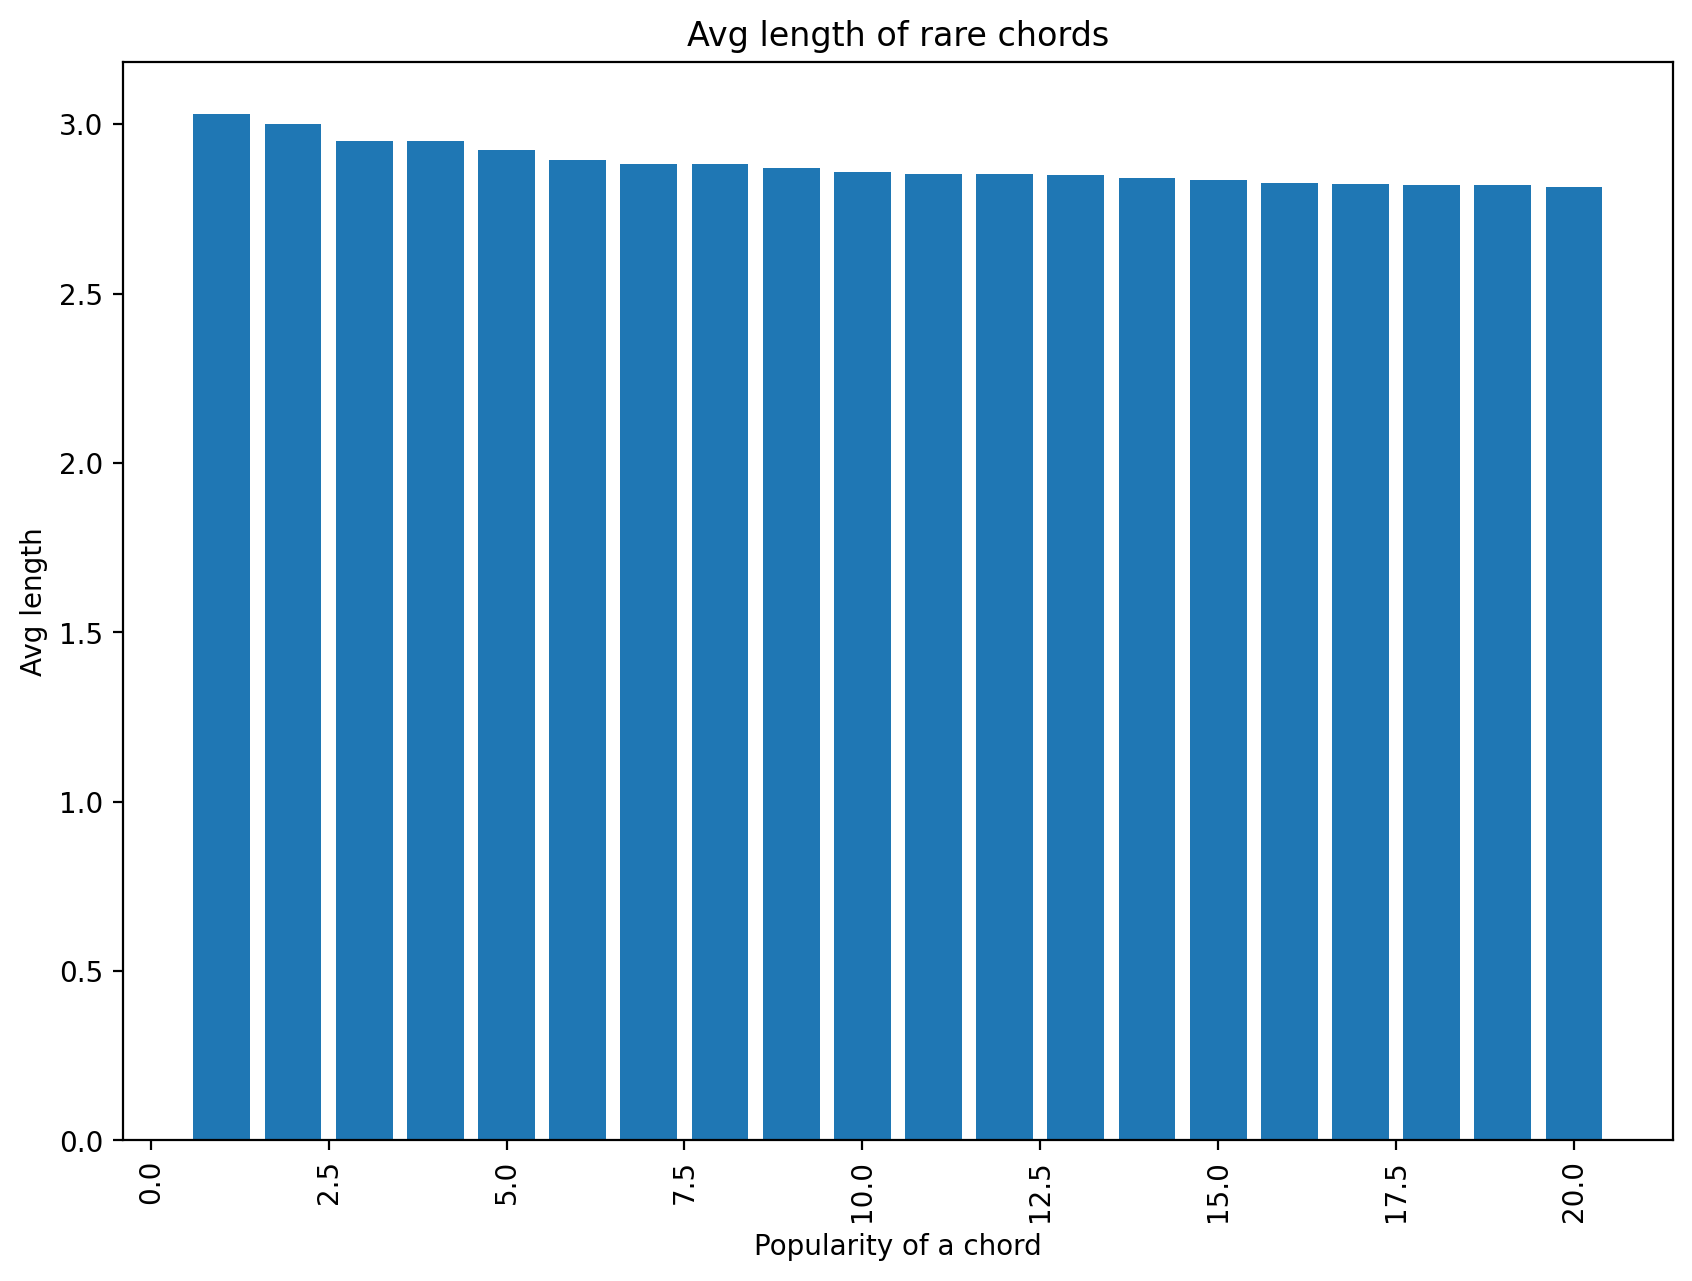

In [21]:
# Plotting the means
plt.figure(figsize=(10, 7))

# Create a bar chart using the plot function
plt.bar(list(range(1, HOW_MANY + 1)), means)

# Add a title and axis labels
plt.title('Avg length of rare chords')
plt.xlabel('Popularity of a chord')
plt.ylabel('Avg length')

# Rotate labels
plt.xticks(rotation=90)

# Display the plot
plt.show()

The avg length is around 3 for the rare chords, so I can probably shorten them to 2 notes for the encoding purposes, so i don't have to use 1881 different values

## Visualize melodies

In [22]:
import music21
from IPython.display import Image, Audio

def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
    try:
        filename = music.write('mid')
        os.system(f'fluidsynth -ni font.sf2 {filename} -F {filename}.wav -r 16000 > /dev/null')
        display(Audio(f'{filename}.wav'))
    except Exception as e:
        print(f'Error: {e}')

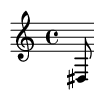

In [23]:
n = music21.note.Note('D#3')
n.duration = duration.Duration(Fraction(1, 3))
show(n)

In [24]:
play(n)

In [25]:
from music21 import chord
def create_midi_part(part_n: music21.stream.Score) -> list:
  melody = get_all_notes(part_n)
  melody_ready = []
  # Create really ugly and unnecessary for loop just for 
  for sound in melody:
    if len(sound[1]) <= 4:
      new_note = note.Note(int(float(sound[1])), quarterLength = sound[2]) # use .nameWithOctave for the names only
    else:
      pitches_str = sound[1].split()
      pitches = [int(float(s)) for s in pitches_str]
      new_note = chord.Chord(pitches, quarterLength = sound[2]) # Must be an int (despite the fact that GPT says otherwise)
    new_note.offset = sound[0]
    melody_ready.append(new_note)
  return melody_ready

In [26]:
melody_visual = create_midi_part(midi_list[1])
melody_midi = stream.Stream(melody_visual)

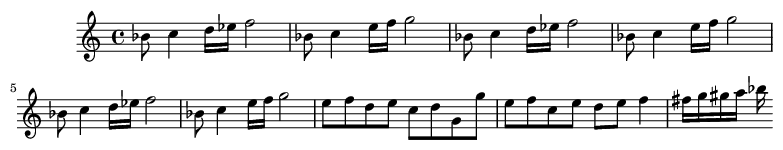

In [27]:
show(melody_midi[:50])

In [28]:
play(melody_midi[:50])

## Simpifying chords and encoding

In [29]:
LIMIT = 8 # Rare chord is shorter or equal to limit
TRIM_TO = 9 # Reduces rare chords to 2 notes
TRIM_TO = TRIM_TO if (TRIM_TO - 4) % 5 == 0 else 9 # Choose correct trim
REMOVE_PAUSES = True # Remove pauses (encoded as 0 by default) from the encoded piece
# Pauses create problems during dataset windowing

In [30]:
### Check if removing rare chords helps
ENCODER = dict() # checking if trimming chords makes any sense at all + creating id for each chord
TRIMMER = dict() # enables transformation of chords
id = 2
for key, value in types.items(): 
  kcp = key[:TRIM_TO] if value <= LIMIT and len(key) > TRIM_TO else key
  TRIMMER[key] = kcp
  if ENCODER.get(kcp) is None:
    ENCODER[kcp] = id
    id += 1

print(len(types), len(ENCODER))

1881 1176


### Encoding and decoding

In [31]:
notes_list[:10]

[[14.0, '70.0', 0.5],
 [15.0, '72.0', 1.0],
 [16.0, '74.0', 0.25],
 [16.5, '75.0', 0.25],
 [17.0, '77.0', 2.0],
 [20.0, '70.0', 0.5],
 [21.0, '72.0', 1.0],
 [22.0, '76.0', 0.25],
 [22.5, '77.0', 0.25],
 [23.0, '79.0', 2.0]]

In [32]:
# Warning!!! This method removes rare chords, so the encoded version may not be the same
# Pause id -> pause, empty_id -> no new notes

def encode_part(notes: list, chord_trans: dict, chords_id: dict, empty_id: int = 1, pause_id: int = 0) -> list:
  sound_list = list()
  for index, value in enumerate(notes[:-1]):
    cnt = int(value[2] * 12)
    offest_dif = int(12 * (notes[index + 1][0] - value[0]))
    for x in range(cnt):
      new_symbol = chords_id[chord_trans[value[1]]] if not x else empty_id
      sound_list.append(new_symbol)
    for _ in range(max(offest_dif - cnt, 0)):
      sound_list.append(pause_id)
  cnt = int(notes[-1][2] * 12)
  for x in range(cnt):
      new_symbol = chords_id[chord_trans[notes[-1][1]]] if not x else empty_id
      sound_list.append(new_symbol)
  return sound_list

In [33]:
part_encoded = encode_part(get_all_notes(midi_list[1]), TRIMMER, ENCODER)
part_encoded[:20]

[68, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 30, 1, 1, 1, 1, 1, 1, 1]

In [34]:
def exclude_pauses(part_encoded):
  return [x for x in part_encoded if x != 0]

In [35]:
if REMOVE_PAUSES:
  part_encoded = exclude_pauses(part_encoded)

In [36]:
# Simply transform notes of len 1/3 into python fractions
def float_to_fraction(x: float):
    frac = Fraction(x).limit_denominator()
    return frac if (frac.denominator % 3 == 0 and frac.numerator % frac.denominator != 0) else x

print(float_to_fraction(0.25), float_to_fraction(0.3333333333333))

0.25 1/3


In [37]:
def decode_part(encoded: list, chords_id_encoder: dict, empty_id: int = 1, pause_id: int = 0) -> list:
  notes_decoded = list()
  counter = 1
  zero_counter = 0
  offset = 0
  last_n = encoded[0]
  for n in encoded[1:]:
    if n not in (empty_id, pause_id):
      notes_decoded.append([offset, chords_id_encoder[last_n], float_to_fraction(counter/12)])
      offset += float((counter + zero_counter) / 12)
      counter = 1
      zero_counter = 0
      last_n = n
    elif n == empty_id:
      counter += 1
    elif n == pause_id:
      zero_counter += 1
  notes_decoded.append([offset, chords_id_encoder[last_n], float_to_fraction(counter/12)])
      
  return notes_decoded

In [38]:
DECODER = {v: k for k, v in ENCODER.items()}
lst = decode_part(part_encoded, DECODER)
lst[:10]

[[0, '70.0', 0.5],
 [0.5, '72.0', 1.0],
 [1.5, '74.0', 0.25],
 [1.75, '75.0', 0.25],
 [2.0, '77.0', 2.0],
 [4.0, '70.0', 0.5],
 [4.5, '72.0', 1.0],
 [5.5, '76.0', 0.25],
 [5.75, '77.0', 0.25],
 [6.0, '79.0', 2.0]]

Warning: there is a certain issue if it comes to midi files. Sometimes 2 separate notes which do not belong to a chord have the same offsets - in that case the offset of the second note is shifted by its length

## Windowing + one hot encoding
As chords and notes are discrete values, one hot encoding might be a good idea ???
As octaves are represented in my encoding as 48 values (4 quarter notes are represented by 12 digits) the horizon value will be 

### Windowing

By default try to predict a single measure using 2 preceding measures 

In [39]:
HORIZON = 48 # 4 quarter notes
WINDOW_SIZE = 96 # 8 quarter notes

In [40]:
# Create function to label windowed data
def get_labelled_windows(x: np.ndarray, horizon=12):
  return x[:, :-horizon], x[:, -horizon:]

In [41]:
def make_windows(x: np.ndarray, window_size: int = WINDOW_SIZE, horizon: int = HORIZON, step: int = None) -> np.ndarray:
  # 0. By default step == window_size
  step = horizon if step is None else step

  # 1. Create a window of specific window size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. Use numpy indexing to create a 2D array of multiple windows
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).transpose()
  # len(x)-(window_size+horizon-1) is used to prevent sliding window from getting out of range
  # Basically for some reason the sum of [[0, 1, 2]] and [[0], [1], [2]] gives you [[0, 1, 2], [1, 2, 3], [2, 3, 4]]

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Divide widowed data
  if step > 1:
    windowed_array = windowed_array[::step]

  # 5. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [42]:
test_windows, test_labels = make_windows(np.array(part_encoded), window_size = WINDOW_SIZE, horizon = HORIZON)

In [43]:
test_windows[:2]

array([[68,  1,  1,  1,  1,  1, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 48,  1,  1, 47,  1,  1, 69,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        68,  1,  1,  1,  1,  1, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 28,  1,  1, 69,  1,  1, 24,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [68,  1,  1,  1,  1,  1, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 28,  1,  1, 69,  1,  1, 24,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        68,  1,  1,  1,  1,  1, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 48,  1,  1, 47,  1,  1, 69,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

In [44]:
test_labels[:2]

array([[68,  1,  1,  1,  1,  1, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 48,  1,  1, 47,  1,  1, 69,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [68,  1,  1,  1,  1,  1, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 28,  1,  1, 69,  1,  1, 24,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

### Joining, one hot encoding the dataset and creating train/test split

### Joining and creating splits

The function removes pieces shorter than 40 notes by default - I assume there are not very important for the whole dataset. The function does not work properly if the piece given as an argument is shorter than 5 quarter notes

In [47]:
TRAIN_TEST = 0.8
from tensorflow.keras.utils import to_categorical

def join_midis(midi_list: list, 
               trimmer: dict, 
               encoder: dict, 
               train_test: np.float128 = TRAIN_TEST,
               empty_id: int = 1, 
               pause_id: int = 0,
               window_size: int = WINDOW_SIZE, 
               horizon: int = HORIZON) -> np.ndarray:
  
  X_set = None
  y_set = None
  
  for midi in midi_list:
    notes = get_all_notes(midi)
    if len(notes) < window_size + horizon:
      continue

    notes_encoded = encode_part(notes, trimmer, encoder)

    windows, labels = make_windows(np.array(part_encoded), 
                                   window_size = window_size, 
                                   horizon = horizon)

    if X_set is None:
      X_set = windows
      y_set = labels
    else:
      X_set = np.concatenate([X_set, windows])
      y_set = np.concatenate([y_set, labels])

  divider = int(len(X_set) * train_test)

  return X_set[:divider], y_set[:divider], X_set[divider:], y_set[divider:]

In [48]:
X_train, y_train, X_test, y_test = join_midis(midi_list, TRIMMER, ENCODER)

In [49]:
print([len(x) for x in [X_train, y_train, X_test, y_test]])

[2782, 2782, 696, 696]


In [52]:
X_train[:2]

array([[68,  1,  1,  1,  1,  1, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 48,  1,  1, 47,  1,  1, 69,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        68,  1,  1,  1,  1,  1, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 28,  1,  1, 69,  1,  1, 24,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [68,  1,  1,  1,  1,  1, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 28,  1,  1, 69,  1,  1, 24,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        68,  1,  1,  1,  1,  1, 30,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, 48,  1,  1, 47,  1,  1, 69,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])

### One hot encoding

In [54]:
# Backup (prevents colab RAM explosions)
"""import csv

for index, value in enumerate((X_train, y_train, X_test, y_test)):
  with open(f'set_{index}.csv', 'w', newline='') as f:
      writer = csv.writer(f)
      writer.writerows(value)"""

In [59]:
import tensorflow as tf

# Determine the number of unique labels
num_labels = len(ENCODER) + (1 if REMOVE_PAUSES else 2)

# One-hot encode the labels
X_train_hot = tf.one_hot(X_train, num_labels)
y_train_hot = tf.one_hot(y_train, num_labels)
X_test_hot = tf.one_hot(X_test, num_labels)
y_test_hot = tf.one_hot(y_test, num_labels)

### Create datasets

In [60]:
BATCH_SIZE = 64

# Combine chars and tokens into a dataset - not necessary, but it's a good reminder
train_data = tf.data.Dataset.from_tensor_slices(X_train)
train_labels = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_data, train_labels))

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices(X_test)
test_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_dataset = tf.data.Dataset.zip((test_data, test_labels))

test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## LSTM

In [62]:
# Check shape of the dataset
y_train_hot.shape

TensorShape([2782, 48, 1177])

In [ ]:
from tensorflow import expand_dims
from tensorflow.keras import layers

tf.random.set_seed(42)

inputs = layers.Input(shape=(HORIZON, num_labels), dtype=tf.float32)
x = layers.LSTM(128, return_sequences=True)(inputs)
x = layers.Dropout(0.1)(x)
x = layers.LSTM(128)(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32)(x)
output = layers.Dense(NOTE_PARAMS, activation="softmax")(x)
model_lstm = tf.keras.Model(inputs=inputs, outputs=output, name="model_lstm")

model_lstm.compile(loss="mae",
                optimizer="Adam",
                metrics=["mae", "mse"])

history_lstm = model_lstm.fit(x=X_train,
                              y=y_train,
                              epochs=3,
                              verbose=0,
                              validation_data=(X_test, y_test))